In [4]:
# Initialize Otter
import otter
grader = otter.Notebook("lab.ipynb")

# Lab 8 – Feature Engineering ⚙️

## DSC 80, Fall 2022

### Due Date: Monday, November 21st at 11:59PM

## Instructions
Much like in DSC 10, this Jupyter Notebook contains the statements of the problems and provides code and Markdown cells to display your answers to the problems. Unlike DSC 10, the notebook is *only* for displaying a readable version of your final answers. The coding will be done in an accompanying `lab.py` file that is imported into the current notebook.

<span style='color:red'><b>Note: For Lab 8, there are no hidden tests!</b></span> The tests you see when you run `grader.check` are the final tests that will determine your grade. In addition, when you submit Lab 8 to Gradescope you will see your final score on the assignment right away.

Labs and programming assignments will be graded in (at most) two ways:
1. The functions and classes in the accompanying `lab.py` file will be tested (a la DSC 20),
2. The notebook may be graded (if it contains free response questions or asks you to draw plots).

**Do not change the function names in the `lab.py` file!**
- The functions in the `lab.py` file are how your assignment is graded, and they are graded by their name.
- If you changed something you weren't supposed to, just use git to revert! Ask us if you need help with this, or google around for `git revert`.

**Tips for working in the notebook**:
- The notebooks serve to present the questions and give you a place to present your results for later review.
- The notebooks in *lab assignments* are not graded (only the `lab.py` file is submitted and graded).
- The notebook serves as a nice environment for 'pre-development' and experimentation before designing your function in your `lab.py` file. You can write code here, but make sure that all of your real work is in the `lab.py` file.

**Tips for developing in the `lab.py` file**:
- Do not change the function names in the starter code; grading is done using these function names.
- Do not change the docstrings in the functions. These are there to tell you if your work is on the right track!
- You are encouraged to write your own additional helper functions to solve the lab! 
- Always document your code!

### Importing code from `lab.py`

* We import our `lab.py` file that's contained in the same directory as this notebook.
* We use the `autoreload` notebook extension to make changes to our `lab.py` file immediately available in our notebook. Without this extension, we would need to restart the notebook kernel to see any changes to `lab.py` in the notebook.
    - `autoreload` is necessary because, upon import, `lab.py` is compiled to bytecode (in the directory `__pycache__`). Subsequent imports of `lab` merely import the existing compiled python.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lab import *

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import Binarizer, QuantileTransformer, FunctionTransformer

import warnings
warnings.filterwarnings('ignore')

***Note:*** While working on the lab, check the Campuswire post titled "Lab 8 Released!" for any clarifications.

## Part 1: Scaling Transformations 📐

A scaling transformation transforms the scale of the data of a particular quantitative column. Mathematically, each data point $d_i$ is replaced with a transformed value $t_i = f(d_i)$, where $f$ is a transformation function. We can transform any column in a dataset, whether it corresponds to a feature or a target.

Generally, the goal of a scaling transformation is to change the data from a complicated, non-linear relationship into a **linear** relationship. Linear relationships are very easy to understand and are easily used by models, like linear regression.

However, non-linear growth is a commonly seen relationship in data. Sometimes this growth is by a **fixed power** and sometimes it is **exponential**. The scaling transformations that turn these types of growth linear are **root** and **log** transformations respectively. (Generally, it is more difficult to determine which transformation is appropriate for a given dataset, though the [Tukey-Mosteller bulge diagram](https://freakonometrics.hypotheses.org/files/2014/06/Selection_005.png) is useful.)

Let's start by looking at some examples of transformations.

#### Example 1

Run the cell below to generate a scatter plot.

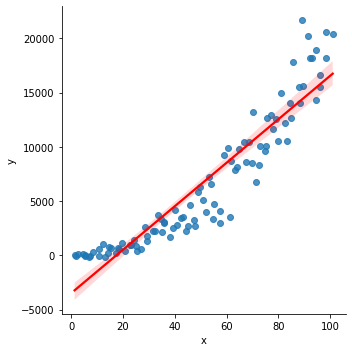

In [5]:
# By setting a seed, we guarantee that we will see the same results each time we run this cell
np.random.seed(23)

# Generates a random scatter plot
x = np.arange(1, 101) + np.random.normal(0, 0.5, 100)
y = 2 * ((x + np.random.normal(0, 1, 100)) ** 2) + np.abs(x) * np.random.normal(0, 30, 100)
df_1 = pd.DataFrame().assign(x=x, y=y)

sns.lmplot(data=df_1, x='x', y='y', line_kws={'color': 'red'});

It doesn't appear to be the case that `'x'` and `'y'` are linearly associated here, and they aren't – there is a **quadratic** relationship between them. Note that if we were to create a **residual plot** above, there would be a pattern – the residuals for smaller `'x'` would mostly be positive, and the residuals for larger `'x'` would mostly be negative. From [DSC 10](https://inferentialthinking.com/chapters/15/5/Visual_Diagnostics.html), we know that patterns in a residual plot imply that the relationship between the two variables is non-linear.

To linearize the relationship, we can take the square root of each `'y'` value:

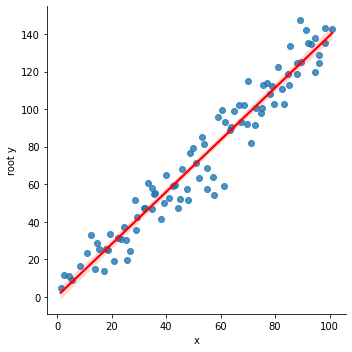

In [6]:
df_1['root y'] = np.sqrt(df_1['y'])

sns.lmplot(data=df_1, x='x', y='root y', line_kws={'color': 'red'});

That looks much better!

#### Example 2

Run the cell below to generate another scatter plot.

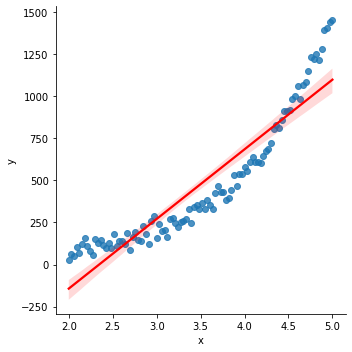

In [7]:
# By setting a seed, we guarantee that we will see the same results each time we run this cell
np.random.seed(32)

# Generates a different random scatter plot
x = np.linspace(2, 5, 100)
y = 10 * (np.e ** x) + np.abs(x) * np.random.normal(0, 5, 100) + np.random.normal(0, 30, 100)
df_2 = pd.DataFrame().assign(x=x, y=y)

sns.lmplot(data=df_2, x='x', y='y', line_kws={'color': 'red'});

Again, the relationship between `'x'` and `'y'` is not quite linear. Let's try the square root transformation we tried in Example 1:

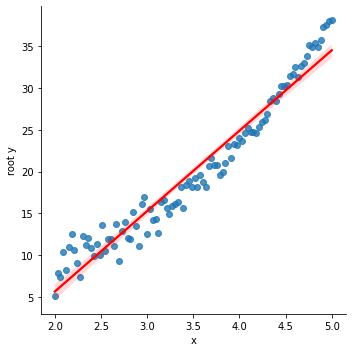

In [8]:
df_2['root y'] = np.sqrt(df_2['y'])

sns.lmplot(data=df_2, x='x', y='root y', line_kws={'color': 'red'});

Hmm... the relationship certainly looks _more_ linear than before, but still not quite linear. Let's look at the residual plot:

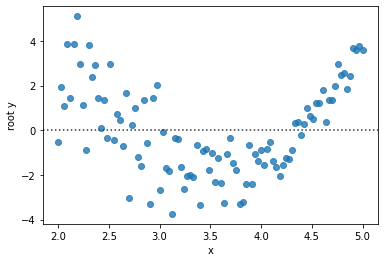

In [9]:
sns.residplot(data=df_2, x='x', y='root y');

There is clearly a pattern in the residual plot. Let's instead try another transformation for the `'y'` values – $\log$.

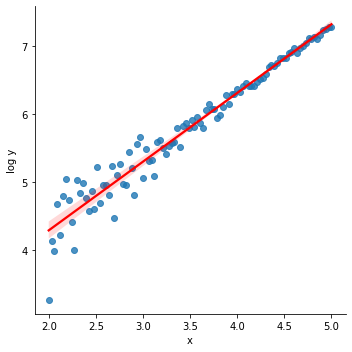

In [10]:
df_2['log y'] = np.log(df_2['y'])

sns.lmplot(data=df_2, x='x', y='log y', line_kws={'color': 'red'});

That looks much better! We can verify that the residual plot has no "patterns":

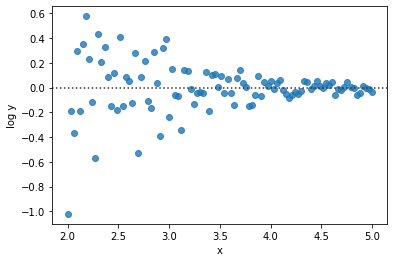

In [11]:
sns.residplot(data=df_2, x='x', y='log y');

Note – there is still evidence of **heteroscedasticity**, or "uneven spread", in this scatter plot, but the relationship is as close to linear as we'll get.

### Question 1 –  Root vs. Log

Now that we've learned how to perform transformations with example datasets, it's your job to apply these ideas to a real dataset. Below, you are given a dataset that describes the [number of home runs in the MLB per year](https://www.mlb.com/glossary/standard-stats/home-run). The relationship between the two variables, `'Year'` and `'Homeruns'`, is not linear.

**Specifically, your job is to determine what the appropriate transformation to apply to the `'Home runs'` column is, in order to linearize the relationship.**

Create a function `best_transformation` that returns either 1, 2, 3, or 4, with the value corresponding to one of the following choices:

1. Square root transformation.
2. Log transformation.
3. Both work the same.
4. Neither gives a transformation revealing a linear relationship.

In [12]:
homeruns_fp = os.path.join('data', 'homeruns.csv')
homeruns = pd.read_csv(homeruns_fp)

In [16]:
def best_transformation():
    """
    Returns an integer corresponding to the correct option.

    :Example:
    >>> best_transformation() in [1, 2, 3, 4]
    True
    """
    return 1

In [17]:
best_transformation()

1

In [18]:
grader.check("q1")

q1 results: All test cases passed!

## Part 2: Diamond Pricing 💎

In this next section, you will pretend you are a jewelry appraiser and predict the prices of diamonds given several standard characteristics of diamonds.

You will use linear regression to predict prices, while improving the quality of your predictions using **feature engineering**. Since this question is supposed to help you understand feature engineering, **you will be building these features from scratch, instead of using the built in `sklearn` or `pandas` methods**.

The `diamonds` dataset is accessible via `seaborn` (with `sns.load_dataset('diamonds')`), but we've skipped that step and loaded it for you below. The DataFrame has 53940 rows and 10 columns:

|column|description|unique values or range|
|---|---|---|
|`'carat'`|weight of the diamond in carats (each carat is 0.2 grams)| 0.2 - 5.01 |
|`'cut'`|quality of the cut | Fair, Good, Very Good, Premium, Ideal |
|`'color'`|diamond colour | J (worst, near colorless), I, H, G, F, E, D (best, absolute colorless) |
|`'clarity'`|a measurement of how clear the diamond is | I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best) |
|`'depth'`|total depth percentage, computed as z / mean(x, y) = 2 * z / (x + y) | 43 - 79 |
|`'table'`|width of top of diamond relative to widest point | 43 - 95 |
|`'price'`|price in US dollars | \\$326 - \\$18,823 USD |
|`'x'`|length in mm | 0 - 10.74 |
|`'y'`|width in mm | 0 - 58.9 | 
|`'z'`|depth in mm | 0 - 31.8 |

If you want to learn more about how diamonds are measured, refer to [this page by the American Gem Society](https://www.americangemsociety.org/4cs-of-diamonds/).

In [16]:
diamonds = pd.read_csv(os.path.join('data', 'diamonds.csv'))
diamonds.head()

### Question 2 – Ordinal Encoding 🔢

Every categorical variable in the dataset is an ordinal column, meaning that there is an inherent order that we can use to sort the values in the column. Recall that **ordinal encoding** is a feature transformation that maps the values in an ordinal column to positive integers in a way that preserves the order of the column values. For instance, an ordinal encoding for Freshman, Sophomore, Junior, Senior is 0, 1, 2, 3.

Create a function `create_ordinal` that takes in `diamonds` and returns a DataFrame of ordinal features only with names `'ordinal_<col>'` where `'<col>'` is the original categorical column name. For instance, the `'ordinal_color'` column should consist of values from 0 to 6, where 0 refers to `'J'` and 6 refers to `'D'`. (In all cases, start counting from 0.)

***Notes:*** 
- Remember, you are creating this function using basic `pandas`. You should create a helper function that takes in a single column and an ordering for that column!
- Don't include non-ordinal features in the returned DataFrame. That is, if there are only three columns in `diamonds` that are ordinal, `create_ordinal` should return a DataFrame with three columns.

In [18]:
# don't change this cell, but do run it -- it is needed for the tests to work
diamonds = pd.read_csv(os.path.join('data', 'diamonds.csv'))
out_q2 = create_ordinal(diamonds)

In [ ]:
grader.check("q2")

### Question 3 – Nominal Encoding 📊

Even though the categorical variables in the dataset are ordinal, we can still treat them as nominal by forgetting about the ordering of the columns. To treat the categorical variables in our dataset as nominal, we might **one-hot encode** them. 

#### `create_one_hot`

Create a function `create_one_hot` that takes in `diamonds` and returns a DataFrame of one-hot encoded features with names `'one_hot_<col>_<val>'` where `'<col>'` is the original categorical column name, and `'<val>'` is the value found in the categorical column `'<col>'`. For instance, one of your column names will be `'one_hot_color_J'`.

***Notes:***
- Only include one-hot-encoded columns in the DataFrame that `create_one_hot` returns.
- Create a helper function that creates the one-hot encoding for a single column. **Do not** use `sklearn` or `pd.get_dummies` for this question!
- As per usual, write an efficient implementation. You may use a `for`-loop over **columns**, but not over rows.
- In lecture, we will look at cases where we need to drop one one-hot encoded column per categorical variable. **Do not drop** any one-hot encoded columns here!

<br>

#### `create_proportions`

Similar to the one-hot encoding case, you can replace a value in a nominal column with the likelihood that value appears in the column. For instance, if a column consists of the values `['a', 'b', 'a', 'c']`, then the proportion-encoded column is `[0.5, 0.25, 0.5, 0.25]`.  This might be a reasonable approach to predicting the price of a diamond, as you might expect *rarer attributes to be considered more valuable* than common ones.

Create a function `create_proportions` that takes in `diamonds` and returns a DataFrame of proportion-encoded features with names `'proportion_<col>'` where `'<col>'` is the original categorical column name.

In [29]:
# don't change this cell, but do run it -- it is needed for the tests to work
diamonds = pd.read_csv(os.path.join('data', 'diamonds.csv'))
out1_q3 = create_one_hot(diamonds)
out2_q3 = create_proportions(diamonds)

In [ ]:
grader.check("q3")

### Question 4 – Quadratic Features 📈

Linear regression doesn't capture non-linear relationships between variables. However, you can create features that encode such dependencies **before** fitting your regression model. Creating polynomial features is one way to do this. For example, the `diamonds` dataset contains each dimension for the stone (`x`,`y`,`z`). However, different combinations of size may be more valuable than others: a "deep and wide" diamond might be considered more valuable than a shallow, but "long and wide" diamond.

Create a function `create_quadratics` that takes in `diamonds` and returns a DataFrame of quadratic features `'<col1> * <col2>'` where `'<col1>'` and `'<col2>'` are the original quantitative columns. The output DataFrame should contain a column for every distinct pair of quantitative columns in `diamonds` (aside from `price`, which should be left out as it is what we are predicting). For instance, one of the columns in the returned DataFrame should named either `'carat * x'` or `'x * carat'`; the order of column names is not important.

***Notes:***
- Again, **do not** use `sklearn` for this question! 
- Try finding all pairs of quantitative columns efficiently; don't use a nested loop (hint: you may `import itertools`). Our solution contains just a single `for`-loop (over pairs of columns).

In [42]:
# don't change this cell, but do run it -- it is needed for the tests to work
diamonds = pd.read_csv(os.path.join('data', 'diamonds.csv'))
out_q4 = create_quadratics(diamonds)

In [ ]:
grader.check("q4")

### Question 5 – Comparing Performance 🏆

We've now created several sets of features. **Which features are best able to predict the price of a diamond in a linear regression model?** We'll look at both single-feature linear regression models and multiple regression models. In all cases, use the default arguments to `sklearn`'s `LinearRegression` object (i.e. assume there is an intercept term).

#### Single-Feature Models

- (1) Fit a single-feature linear regression model on `'carat'`. What is the $R^2$ of the model? (Note that `'carat'` turns out to be the best single feature to use in a linear model that predicts price.)
- (2) What is the RMSE of the model you created in (1)?
- (3) Amongst the other **quantitative** features present in the original `diamonds`, which produces the single-feature linear regression model with the highest $R^2$?
- (4) Amongst all the new features you created in Questions 2-4, which produces the single-feature linear regression model with the highest $R^2$?
- (5) Amongst the new categorical features you created in Question 2 and 3, which produces the single-feature linear regression model with the highest $R^2$? 

#### Multiple Regression

Now, fit a multiple regression model using:
- the quantitative columns that were present in the original `diamonds` dataset, and
- the quantitative features engineered in Question 4

as features. (Don't use any of the encodings of categorical columns from Questions 2 and 3.)

- (6) What is the RMSE of this new model?


<br>

Create a function `comparing_performance` that returns a list containing the answers to the 6 questions numbered (1), (2), ..., (6) above. You don't need to round any of your answers.

***Hint:*** Repeatedly use the `sklearn` pattern included below. It's a good idea to make a helper function that takes in a column, performs single-feature regression using the input column as the feature, and returns the $R^2$ and RMSE of the model.

In [53]:
from sklearn.linear_model import LinearRegression

# X = ...
# y = ...

# lr = LinearRegression()
# lr.fit(X, y)  # X is a DataFrame of training data; y is a Series of prices
# lr.score(X, y)  # R-squared
# lr.predict(X) # predicted prices

In [54]:
# don't change this cell, but do run it -- it is needed for the tests to work
import numbers
out_q5 = comparing_performance()

In [ ]:
grader.check("q5")

## Part 3 – Feature Engineering with `sklearn` 🧠

In this final question, you will use `sklearn`'s transformers and estimators for feature engineering. While everything you do with `sklearn` is possible to do with `pandas`, `sklearn` transformers enable you to couple your feature engineering with your modeling. This will allow you to more quickly build and assess your models in `sklearn`.

Specifically, you will create a `TransformDiamonds` class that contains the three methods specified below – `transform_carat` (6.1), `transform_to_quantile` (6.2), and `transform_to_depth_pct` (6.3). In the starter code, there is a skeleton for `TransformDiamonds` that is initialized with a DataFrame `diamonds`.

Each of the methods you implement in the `TransformDiamonds` class should take in a DataFrame, initialize a specific `sklearn.Transformer` object (like `Binarizer` or `FunctionTransformer`), and use the transformer to transform columns from the input DataFrame. You should **not** use DataFrame methods like `apply` in this problem.

In [67]:
from sklearn.preprocessing import Binarizer, QuantileTransformer, FunctionTransformer

Question 6 is made up of the three subparts below.

### Question 6.1 – Transforming a Quantitative Column into a Binary Column (`transform_carat`)

We call a diamond **large** if its weight is strictly greater than 1 carat. We want to **binarize** weights, so that they are 1 for large diamonds and 0 for small diamonds. Create a method `transform_carat` that takes in a DataFrame like `diamonds` and returns a binarized **array** of weights. Use a `Binarizer` object as your transformer.

***Note:*** You will return an array, not a Series, because `sklearn` thinks in terms of `np.ndarray`s, not DataFrames.

In [69]:
# don't change this cell, but do run it -- it is needed for the tests to work
diamonds = pd.read_csv(os.path.join('data', 'diamonds.csv'))
q6a_trans = TransformDiamonds(diamonds)
q6a_out = q6a_trans.transform_carat(diamonds)

In [ ]:
grader.check("q6.1")

### Question 6.2 – Transforming a Quantitative Column into Quantiles (`transform_to_quantile`)

You will now transform the `'carat'` column so that each diamond's weight in carats is replaced with the **percentile** amongst all diamonds in which its weight lies.

Create a method `transform_to_quantiles` that takes in a DataFrame like `diamonds` and returns an array containing the percentiles of the weight of each diamond, amongst all diamonds in `self.data`. This array should consist of proportions between 0 and 1; for instance, 0.65 will refer to the 65th percentile. The relevant transformer is `QuantileTransformer`. 

Some guidance:

- Unlike with `Binarizer`, you need to `fit` your `QuantileTransformer` before calling `transform` on the input DataFrame `data`. 
    - You should `fit` your transformer on the DataFrame `self.data`, but you should only `transform` the `data` that is passed to `transform_to_quantiles`. 
    - Note that these two DataFrames, `self.data` and `data`, don't have to be the same! For instance, in the last two lines of the testing setup cell below, we fit a `QuantileTransformer` using just the first 1000 rows of `diamonds`, and then `transform` the entire `diamonds` DataFrame. Make sure your `transform_to_quantiles` method works in such a case.
- When initializing your `QuantileTransformer`, use `n_quantiles=100`.

In [78]:
# don't change this cell, but do run it -- it is needed for the tests to work
q6b_trans = TransformDiamonds(diamonds)
q6b_out = q6b_trans.transform_to_quantile(diamonds)
q6b_trans_top_1000 = TransformDiamonds(diamonds[:1000])
q6b_out_top_1000 = q6b_trans_top_1000.transform_to_quantile(diamonds)

In [ ]:
grader.check("q6.2")

### Question 6.3 – Transforming a Quantitative Column Using a Formula

Recall from the introduction to Part 2 that the "depth percentage" of a diamond is defined as

$$\text{Depth Pct.} = 100\% \cdot \frac{2z}{x + y}$$

where $x$, $y$, and $z$ come from the `'x'`, `'y'`, and `'z'` columns in `diamonds`.

Let's suppose that for some reason we don't have access to the `'depth'` column in `diamonds`, and instead need to recreate it just by looking at the `'x'`, `'y'`, and `'z'` columns. 

Create a method `transform_to_depth_pct` that takes in a DataFrame like `diamonds` and returns an array consisting of the depth percentages of each diamond. Percentages should be between 0 and 100. The relevant transformer is `FunctionTransformer`.

***Notes:***
- To use `FunctionTransformer`, you will need to define your own function that takes in a 2D array and returns a single array.
- Ignore `ZeroDivisionError` errors, and leave `np.NaN`s as is.
- To verify your work, compare your outputted array to the actual `'depth'` column in `diamonds`.
- It may seem like `FunctionTransformer` is totally unnecessary, since we can compute depth percentages using broadcasting directly. However, as we will see in lecture, transformers can be **pipelined** with other processing steps which greatly simplifies our code.

In [88]:
# don't change this cell, but do run it -- it is needed for the tests to work
diamonds = pd.read_csv(os.path.join('data', 'diamonds.csv'))
q6c_trans = TransformDiamonds(diamonds)
q6c_out = q6c_trans.transform_to_depth_pct(diamonds)

In [ ]:
grader.check("q6.3")

## Congratulations! You're done! 🏁

Submit your `lab.py` file to Gradescope. Note that you only need to submit the `lab.py` file; this notebook should not be uploaded.

Before submitting, you should ensure that all of your work is in the `lab.py` file. You can do this by running the doctests below, which will verify that your work passes the public tests **and** that your work is in the `lab.py` file. Run the cell below; you should see no output.

In [95]:
!python -m doctest lab.py

In addition, `grader.check_all()` will verify that your work passes the public tests.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()